# Transformer Models Advanced Training Guide
This guide is showing advanced features of RecTools transformer models training.

### Table of Contents

* Prepare data
* Advanced training guide
    * Validation fold
    * Validation loss
    * Callback for Early Stopping
    * Callbacks for Checkpoints
        * Loading Checkpoints
    * Callbacks for RecSys metrics
        * RecSys metrics for Early Stopping anf Checkpoints
* Advanced training full example
    * Running full training with all of the described validation features on Kion dataset
* More RecTools features for transformers
    * Saving and loading models
    * Configs for transformer models
        * Classes and function in configs
    * Multi-gpu training


In [1]:
import os
import typing as tp
import warnings

import pandas as pd
import numpy as np
import torch
from lightning_fabric import seed_everything
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import   Callback
from rectools.dataset import Dataset
from rectools.models import HSTUModel
from rectools.models.nn.item_net import IdEmbeddingsItemNet
from rectools import Columns, ExternalIds
from scipy import sparse
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
from rectools.model_selection import LastNSplitter
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
from rectools.metrics import (
    MAP,
    CoveredUsers,
    Intersection,
    Serendipity,
    NDCG,
    AvgRecPopularity,
    CatalogCoverage,
    Recall,
    SufficientReco,
)
from rectools.models import  SASRecModel, BERT4RecModel
from rectools.model_selection import  cross_validate
from rectools.models.nn.item_net import IdEmbeddingsItemNet
from rectools.visuals import MetricsApp
import cffi
import zmq  # pyzmq
import notebook  # jupyter
import seaborn as sns
import matplotlib.pyplot as plt

## Prepare data

%%time
!wget -q https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ml-1m.zip
!unzip -o ml-1m.zip
!rm ml-1m.zip

In [2]:
%%time
ratings = pd.read_csv(
    "ml-1m/ratings.dat", 
    sep="::",
    engine="python",  # Because of 2-chars separators
    header=None,
    names=[Columns.User, Columns.Item, Columns.Weight, Columns.Datetime],
)
print(ratings.shape)
ratings[Columns.Weight] = 1
ratings.head()

(1000209, 4)
CPU times: user 3.48 s, sys: 191 ms, total: 3.67 s
Wall time: 3.66 s


,user_id,item_id,weight,datetime
0,1,1193,1,978300760
1,1,661,1,978302109
2,1,914,1,978301968
3,1,3408,1,978300275
4,1,2355,1,978824291


In [3]:
ratings[Columns.Datetime] = ratings[Columns.Datetime].astype("datetime64[s]")

In [4]:
dataset = Dataset.construct(ratings)

In [5]:
RANDOM_STATE=60
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

Seed set to 60


60

In [6]:
paper_df =  pd.read_csv("sasrec_format_2m.csv")
paper_df.head()

,index,user_id,sequence_item_ids,sequence_ratings,sequence_timestamps,sex,age_group,occupation,zip_code
0,4260,4261,"260,2302,2312,2154,902,2616,745,720,3429,1223,...","5,4,3,3,3,2,5,3,3,5,3,5,3,4,3,5,3,5,5,5,4,3,5,...","965305148,965305148,965305189,965305189,965305...",0,3,6,346
1,4645,4646,"337,2587,409,260,1210,1288,2153,2858,3147,2959...","3,2,2,4,4,2,1,5,4,2,3,4,3,3,4,4,1,1,3,5,5,3,4,...","963968496,963968496,963968496,963968496,963968...",0,2,6,2796
2,990,991,"2670,278,1968,1198,1097,1235,2396,1277,2243,91...","2,3,4,4,2,5,3,3,4,4,3,3,4,3,4,4,4,3,5,3,4,3,5,...","975086183,975086297,975086297,975086414,975086...",0,2,9,1597
3,4261,4262,"1097,1226,1373,858,1081,1173,3751,3770,3763,37...","4,5,4,5,4,2,5,3,3,3,4,5,4,3,4,4,3,4,4,5,4,4,4,...","965305021,965305021,965305046,965305046,965305...",0,3,6,286
4,3297,3298,"1746,2496,1805,1993,1614,3095,2858,2188,2706,2...","3,3,5,2,5,4,5,4,4,3,4,5,5,5,5,4,5,5,4,4,5,5,5,...","968047151,968047191,968047228,968047285,968047...",1,0,10,822


In [7]:
paper_df = paper_df[["index","user_id", "sequence_item_ids", "sequence_ratings", "sequence_timestamps"]]

In [8]:
import pandas as pd
import ast

cols_to_expand = ["sequence_item_ids", "sequence_ratings", "sequence_timestamps"]

# Преобразуем строки в списки
for col in cols_to_expand:
    paper_df[col] = paper_df[col].apply(ast.literal_eval)

# Разбираем на отдельные строки
expanded_df = paper_df[["user_id"] + cols_to_expand]
expanded_df = expanded_df.explode(cols_to_expand)

# Переименовываем
expanded_df = expanded_df.rename(columns={
    "sequence_item_ids": "item_id",
    "sequence_ratings": "rating",
    "sequence_timestamps": "timestamp"
})

# Приводим к правильным типам
expanded_df["item_id"] = expanded_df["item_id"].astype(int)
expanded_df["rating"] = expanded_df["rating"].astype(float)
expanded_df["timestamp"] = expanded_df["timestamp"].astype(int)
expanded_df["datetime"] = pd.to_datetime(expanded_df["timestamp"], unit="s")
expanded_df = expanded_df.drop(columns=["timestamp"])
expanded_df.reset_index(drop=True, inplace=True)
result = expanded_df[["user_id", "item_id", "datetime"]]
result["weight"] = 1
dataset_orig = Dataset.construct(result)

In [9]:
splitter = LastNSplitter(1,1)

### Validation fold

Models do not create validation fold during `fit` by default. However, there is a simple way to force it.

Let's assume that we want to use Leave-One-Out validation for specific set of users. To apply it we need to implement `get_val_mask_func` with required logic and pass it to model during initialization.

This function should receive interactions with standard RecTools columns and return a binary mask which identifies interactions that should not be used during model training. But instrad should be used for validation loss calculation. They will also be available for Lightning Callbacks to allow RecSys metrics computations.

*Please make sure you do not use `partial` while doing this. Partial functions cannot be by serialized using RecTools.*

In [10]:
def leave_one_out_mask_for_users(
    interactions: pd.DataFrame, val_users: tp.Optional[np.ndarray] = None
) -> np.ndarray:
    time_order = (
        interactions.groupby(Columns.User)[Columns.Datetime]
        .rank(method="first", ascending=True)
        .astype(int)
    )
    df_copy = interactions.copy()
    df_copy["order"] = time_order
    last_interactions_indexes = df_copy.groupby([Columns.User])["order"].idxmax()
    last_interact_mask = df_copy.index.isin(last_interactions_indexes)
    if val_users is not None:
        return (interactions[Columns.User].isin(val_users)) & last_interact_mask
    return last_interact_mask

def get_val_mask_func(interactions: pd.DataFrame):
    return leave_one_out_mask_for_users(interactions, val_users = None)

In [11]:
class RecallCallback(Callback):
    name: str = "recall"
    def __init__(self, k: int, prog_bar: bool = True) -> None:
        self.k = k
        self.name += f"@{k}"
        self.prog_bar = prog_bar

        self.batch_recall_per_users: tp.List[torch.Tensor] = []

    def on_validation_batch_end(
        self,
        trainer: Trainer,
        pl_module: LightningModule,
        outputs: tp.Dict[str, torch.Tensor],
        batch: tp.Dict[str, torch.Tensor],
        batch_idx: int,
        dataloader_idx: int = 0,
    ) -> None:

        if "logits" not in outputs:
            session_embs = pl_module.torch_model.encode_sessions(
                batch, pl_module.item_embs
            )[:, -1, :]
            logits = pl_module.torch_model.similarity_module(
                session_embs, pl_module.item_embs
            )
        else:
            logits = outputs["logits"]

        x = batch["x"]
        users = x.shape[0]
        row_ind = np.arange(users).repeat(x.shape[1])
        col_ind = x.flatten().detach().cpu().numpy()
        mask = col_ind != 0
        data = np.ones_like(row_ind[mask])
        filter_csr = sparse.csr_matrix(
            (data, (row_ind[mask], col_ind[mask])),
            shape=(users, pl_module.torch_model.item_model.n_items),
        )
        mask = torch.from_numpy((filter_csr != 0).toarray()).to(logits.device)
        scores = torch.masked_fill(logits, mask, float("-inf"))

        _, batch_recos = scores.topk(k=self.k)

        targets = batch["y"]

        # assume all users have the same amount of TP
        liked = targets.shape[1]
        tp_mask = torch.stack(
            [
                torch.isin(batch_recos[uid], targets[uid])
                for uid in range(batch_recos.shape[0])
            ]
        )
        recall_per_users = tp_mask.sum(dim=1) / liked

        self.batch_recall_per_users.append(recall_per_users)

    def on_validation_epoch_end(
        self, trainer: Trainer, pl_module: LightningModule
    ) -> None:
        recall = float(torch.concat(self.batch_recall_per_users).mean())
        self.log_dict(
            {self.name: recall}, on_step=False, on_epoch=True, prog_bar=self.prog_bar
        )

        self.batch_recall_per_users.clear()

In this guide we are going to use custom Lighhning trainers. We need to implement function that return desired Lightining trainer and pass it to model during initialization.

In [12]:

# Callback for calculating RecSys metrics
recall_callback = RecallCallback(k=10, prog_bar=True)
# Checkpoint last epoch
last_epoch_ckpt = ModelCheckpoint(filename="last_epoch")
# Checkpoints based on validation loss
least_val_loss_ckpt = ModelCheckpoint(
    monitor="val_loss",   # or just pass "val_loss" here,
    mode="min",
    filename="{epoch}-{val_loss:.2f}",
    save_top_k=2,  # Let's save top 2 checkpoints for validation loss
)

In [13]:
# Function to get custom trainer
def get_debug_trainer() -> Trainer:
    return Trainer(
        accelerator="gpu",
        devices=1,
        min_epochs=101,
        max_epochs=101,
        deterministic=True,
        enable_model_summary=False,
        enable_progress_bar=True,
        callbacks=[recall_callback, last_epoch_ckpt, least_val_loss_ckpt],  # pass our callbacks
        logger = CSVLogger("test_logs"),  # We use CSV logging for this guide but there are many other options
    )

In [14]:
ErrorBehaviour = tp.Literal["ignore", "warn", "raise"]

In [15]:
dataset = Dataset.construct(ratings)

In [16]:
lightning_module_kwargs = {
    "temperature": 0.05
}
session_max_len = 200
common_config = {
    "session_max_len": session_max_len,
    "lightning_module_kwargs": lightning_module_kwargs,
    "item_net_block_types": (IdEmbeddingsItemNet,),
    "get_val_mask_func": get_val_mask_func,  # pass our custom `get_val_mask_func`
    "get_trainer_func": get_debug_trainer,
    "verbose": 1,
    "loss": 'sampled_softmax',
    "n_negatives": 128,
    "use_pos_emb": True,
    "dropout_rate": 0.2,
    "n_factors": 50,
    "n_heads": 1,
    "n_blocks": 2,
    "lr": 0.001,
    "batch_size": 128,
}

In [17]:
hstu_rab_pt  = HSTUModel(    
    relative_time_attention=True,
    relative_pos_attention=True,
    **common_config
)
hstu_rab_p  = HSTUModel(    
    relative_time_attention=False,
    relative_pos_attention=True,
    **common_config
)
hstu_rab_t  = HSTUModel(    
    relative_time_attention=True,
    relative_pos_attention=False,
    **common_config
)
hstu_no_rab  = HSTUModel(    
    relative_time_attention=False,
    relative_pos_attention=False,
    **common_config
)
sasrec = SASRecModel(
    **common_config
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Extra cols:  None
add_unix_ts is : True.
Extra cols:  None
add_unix_ts is : False.
Extra cols:  None
add_unix_ts is : True.
Extra cols:  None
add_unix_ts is : False.
Extra cols:  None
add_unix_ts is : False.


In [18]:
models = {
    "hstu_rab_t": hstu_rab_t,
    "hstu_rab_p": hstu_rab_p,
    "hstu_rab_pt": hstu_rab_pt,
    "hstu_no_rab": hstu_no_rab,
    "sasrec": sasrec,
}

In [19]:

metrics_add = {}
metrics_recall ={}
metrics_ndcg = {}
k_base =  10
K = [10, 50,100,200]
K_RECS= max(K)
for k in K:
    metrics_recall.update({
            f"recall@{k}": Recall(k=k),
        })
    metrics_ndcg.update({
            f"ndcg@{k}": NDCG(k=k, divide_by_achievable=True),
        })
metrics_add = {
    f"arp@{k_base}": AvgRecPopularity(k=k_base, normalize=True),
    f"coverage@{k_base}": CatalogCoverage(k=k_base, normalize=True),
    f"covered_users@{k_base}": CoveredUsers(k=k_base),
    f"sufficient_reco@{k_base}": SufficientReco(k=k_base),
    f"serendipity@{k_base}": Serendipity(k=k_base),
}
metrics  = metrics_recall | metrics_ndcg | metrics_add

In [20]:
cv_results = cross_validate(
    dataset=dataset_orig,
    splitter=splitter,
    models=models,
    metrics=metrics,
    k=K_RECS,
    filter_viewed=True,
)

STU Lyaers dropout 0.2
dropout_rate BackBone 0.2


You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


item_model.item_net_blocks.0.ids_emb.weight torch.Size([3647, 50])
pos_encoding_layer.pos_emb.weight torch.Size([200, 50])
transformer_layers.stu_blocks.0.uvqk_proj torch.Size([50, 200])
transformer_layers.stu_blocks.0.rel_attn.time_weights torch.Size([129])
transformer_layers.stu_blocks.0.output_mlp.weight torch.Size([50, 50])
transformer_layers.stu_blocks.0.output_mlp.bias torch.Size([50])
transformer_layers.stu_blocks.0.norm_input.weight torch.Size([50])
transformer_layers.stu_blocks.0.norm_input.bias torch.Size([50])
transformer_layers.stu_blocks.0.norm_attn_output.weight torch.Size([50])
transformer_layers.stu_blocks.0.norm_attn_output.bias torch.Size([50])
transformer_layers.stu_blocks.1.uvqk_proj torch.Size([50, 200])
transformer_layers.stu_blocks.1.rel_attn.time_weights torch.Size([129])
transformer_layers.stu_blocks.1.output_mlp.weight torch.Size([50, 50])
transformer_layers.stu_blocks.1.output_mlp.bias torch.Size([50])
transformer_layers.stu_blocks.1.norm_input.weight torch.S

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=101` reached.


STU Lyaers dropout 0.2
dropout_rate BackBone 0.2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


item_model.item_net_blocks.0.ids_emb.weight torch.Size([3647, 50])
pos_encoding_layer.pos_emb.weight torch.Size([200, 50])
transformer_layers.stu_blocks.0.uvqk_proj torch.Size([50, 200])
transformer_layers.stu_blocks.0.rel_attn.pos_weights torch.Size([399])
transformer_layers.stu_blocks.0.output_mlp.weight torch.Size([50, 50])
transformer_layers.stu_blocks.0.output_mlp.bias torch.Size([50])
transformer_layers.stu_blocks.0.norm_input.weight torch.Size([50])
transformer_layers.stu_blocks.0.norm_input.bias torch.Size([50])
transformer_layers.stu_blocks.0.norm_attn_output.weight torch.Size([50])
transformer_layers.stu_blocks.0.norm_attn_output.bias torch.Size([50])
transformer_layers.stu_blocks.1.uvqk_proj torch.Size([50, 200])
transformer_layers.stu_blocks.1.rel_attn.pos_weights torch.Size([399])
transformer_layers.stu_blocks.1.output_mlp.weight torch.Size([50, 50])
transformer_layers.stu_blocks.1.output_mlp.bias torch.Size([50])
transformer_layers.stu_blocks.1.norm_input.weight torch.Siz

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=101` reached.


STU Lyaers dropout 0.2
dropout_rate BackBone 0.2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


item_model.item_net_blocks.0.ids_emb.weight torch.Size([3647, 50])
pos_encoding_layer.pos_emb.weight torch.Size([200, 50])
transformer_layers.stu_blocks.0.uvqk_proj torch.Size([50, 200])
transformer_layers.stu_blocks.0.rel_attn.time_weights torch.Size([129])
transformer_layers.stu_blocks.0.rel_attn.pos_weights torch.Size([399])
transformer_layers.stu_blocks.0.output_mlp.weight torch.Size([50, 50])
transformer_layers.stu_blocks.0.output_mlp.bias torch.Size([50])
transformer_layers.stu_blocks.0.norm_input.weight torch.Size([50])
transformer_layers.stu_blocks.0.norm_input.bias torch.Size([50])
transformer_layers.stu_blocks.0.norm_attn_output.weight torch.Size([50])
transformer_layers.stu_blocks.0.norm_attn_output.bias torch.Size([50])
transformer_layers.stu_blocks.1.uvqk_proj torch.Size([50, 200])
transformer_layers.stu_blocks.1.rel_attn.time_weights torch.Size([129])
transformer_layers.stu_blocks.1.rel_attn.pos_weights torch.Size([399])
transformer_layers.stu_blocks.1.output_mlp.weight t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=101` reached.


STU Lyaers dropout 0.2
dropout_rate BackBone 0.2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


item_model.item_net_blocks.0.ids_emb.weight torch.Size([3647, 50])
pos_encoding_layer.pos_emb.weight torch.Size([200, 50])
transformer_layers.stu_blocks.0.uvqk_proj torch.Size([50, 200])
transformer_layers.stu_blocks.0.output_mlp.weight torch.Size([50, 50])
transformer_layers.stu_blocks.0.output_mlp.bias torch.Size([50])
transformer_layers.stu_blocks.0.norm_input.weight torch.Size([50])
transformer_layers.stu_blocks.0.norm_input.bias torch.Size([50])
transformer_layers.stu_blocks.0.norm_attn_output.weight torch.Size([50])
transformer_layers.stu_blocks.0.norm_attn_output.bias torch.Size([50])
transformer_layers.stu_blocks.1.uvqk_proj torch.Size([50, 200])
transformer_layers.stu_blocks.1.output_mlp.weight torch.Size([50, 50])
transformer_layers.stu_blocks.1.output_mlp.bias torch.Size([50])
transformer_layers.stu_blocks.1.norm_input.weight torch.Size([50])
transformer_layers.stu_blocks.1.norm_input.bias torch.Size([50])
transformer_layers.stu_blocks.1.norm_attn_output.weight torch.Size([5

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=101` reached.


dropout_rate BackBone 0.2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


item_model.item_net_blocks.0.ids_emb.weight torch.Size([3647, 50])
pos_encoding_layer.pos_emb.weight torch.Size([200, 50])
transformer_layers.transformer_blocks.0.multi_head_attn.in_proj_weight torch.Size([150, 50])
transformer_layers.transformer_blocks.0.multi_head_attn.in_proj_bias torch.Size([150])
transformer_layers.transformer_blocks.0.multi_head_attn.out_proj.weight torch.Size([50, 50])
transformer_layers.transformer_blocks.0.multi_head_attn.out_proj.bias torch.Size([50])
transformer_layers.transformer_blocks.0.q_layer_norm.weight torch.Size([50])
transformer_layers.transformer_blocks.0.q_layer_norm.bias torch.Size([50])
transformer_layers.transformer_blocks.0.ff_layer_norm.weight torch.Size([50])
transformer_layers.transformer_blocks.0.ff_layer_norm.bias torch.Size([50])
transformer_layers.transformer_blocks.0.feed_forward.ff_linear_1.weight torch.Size([50, 50])
transformer_layers.transformer_blocks.0.feed_forward.ff_linear_1.bias torch.Size([50])
transformer_layers.transformer_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=101` reached.


In [21]:
pivot_results = (
    pd.DataFrame(cv_results["metrics"])
    .drop(columns="i_split")
    .groupby(["model"], sort=False)
    .agg(["mean"])
)
pivot_results.columns = pivot_results.columns.droplevel(1)
pivot_results.to_csv("rectools_transformers_cv.csv", index=True)

In [22]:
pivot_results[metrics_ndcg.keys()]

,ndcg@10,ndcg@50,ndcg@100,ndcg@200
model,,,,
hstu_rab_t,0.173447,0.235614,0.253413,0.265749
hstu_rab_p,0.171514,0.231062,0.249141,0.261084
hstu_rab_pt,0.173095,0.233496,0.251774,0.264025
hstu_no_rab,0.164798,0.223899,0.242361,0.255367
sasrec,0.151265,0.210297,0.229134,0.242979


In [23]:
pivot_results[metrics_recall.keys()]

,recall@10,recall@50,recall@100,recall@200
model,,,,
hstu_rab_t,0.307055,0.587777,0.697416,0.785525
hstu_rab_p,0.304405,0.574197,0.685492,0.770619
hstu_rab_pt,0.308215,0.579993,0.692117,0.779563
hstu_no_rab,0.292481,0.559788,0.673236,0.765982
sasrec,0.279563,0.545545,0.661146,0.760185


In [24]:
pivot_results[metrics_add.keys()]

,arp@10,coverage@10,covered_users@10,sufficient_reco@10,serendipity@10
model,,,,,
hstu_rab_t,0.000923,0.646058,1.0,1.0,0.002706
hstu_rab_p,0.000878,0.658477,1.0,1.0,0.002661
hstu_rab_pt,0.000905,0.652538,1.0,1.0,0.002694
hstu_no_rab,0.000896,0.632829,1.0,1.0,0.002471
sasrec,0.000835,0.673596,1.0,1.0,0.002534


In [25]:
def get_logs(model) -> tp.Tuple[pd.DataFrame, ...]:
    log_path = os.path.join(model.fit_trainer.log_dir, "metrics.csv")
    epoch_metrics_df = pd.read_csv(log_path)

    loss_df = epoch_metrics_df[["epoch", "train_loss"]].dropna()
    val_loss_df = epoch_metrics_df[["epoch", "val_loss"]].dropna()
    loss_df = pd.merge(loss_df, val_loss_df, how="inner", on="epoch")
    loss_df.reset_index(drop=True, inplace=True)

    metrics_df = epoch_metrics_df.drop(columns=["train_loss", "val_loss"]).dropna()
    metrics_df.reset_index(drop=True, inplace=True)

    return loss_df, metrics_df

In [26]:
train_stage_metrics = {
    model_name: get_logs(model)
    for model_name, model in  models.items()
}

In [40]:
models_name = list(models.keys())

In [41]:
def create_subplots_grid(n_plots, n_rows):
    figsize=(12, 4 * n_rows)
    n_rows = (n_plots + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=figsize)

    if n_rows == 1:
        axes = axes.reshape(1, -1)

    if n_plots % 2 == 1:
        axes[-1, -1].axis('off')

    return fig, axes

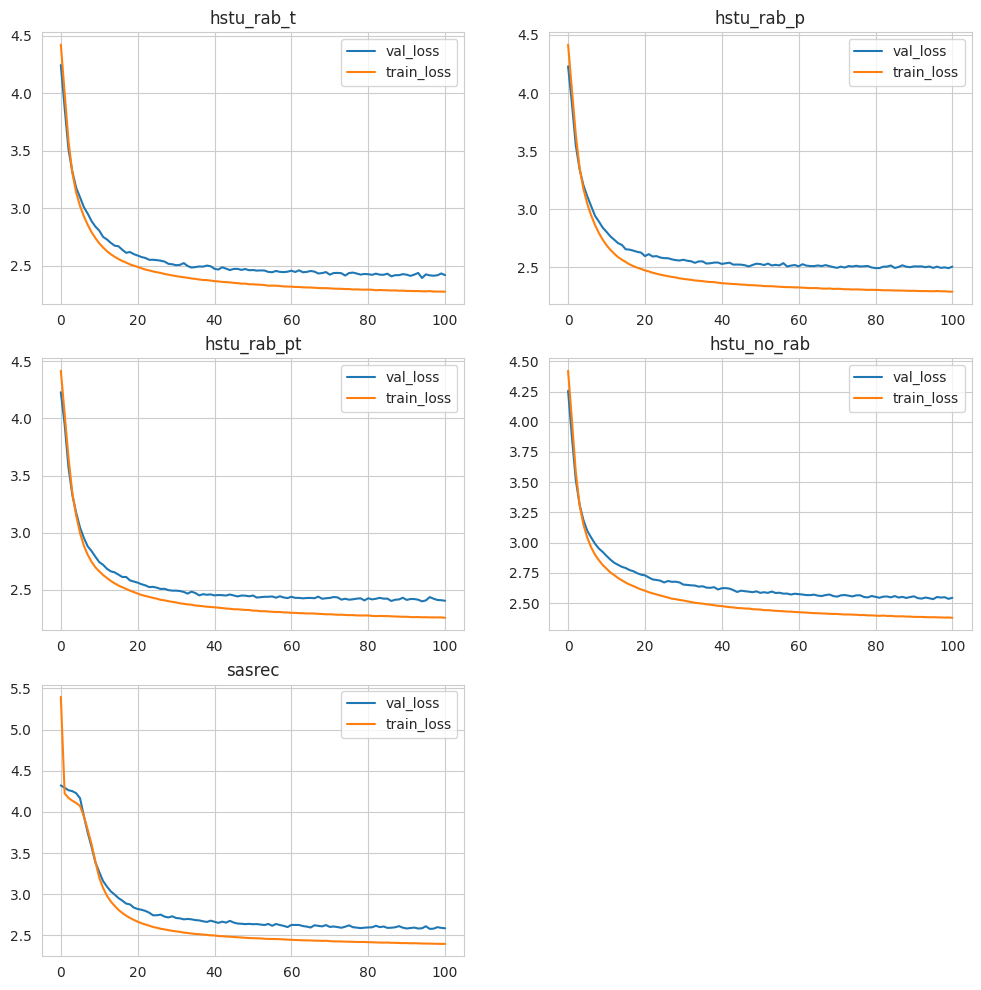

In [60]:
n_plots = len(train_stage_metrics)
fig, axes = create_subplots_grid(n_plots=n_plots, n_rows=3)

for i, (ax, model_name) in enumerate(zip(axes.flat,models_name)):
    if i < 5:
        y1 = train_stage_metrics[model_name][0]["val_loss"]
        y2 = train_stage_metrics[model_name][0]["train_loss"]
        x = train_stage_metrics[model_name][0]["epoch"]
        ax.plot(x, y1, label= "val_loss")
        ax.plot(x, y2, label= "train_loss")
        ax.set_title(f"{model_name}")
        ax.legend()
plt.show()

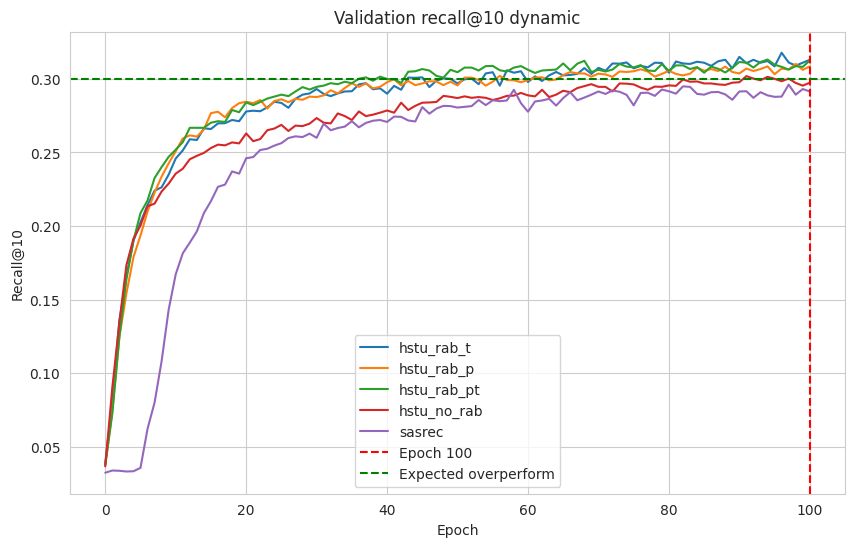

In [28]:
plt.figure(figsize=(10, 6))
for  model_name, tr_results in train_stage_metrics.items():
    plt.plot(tr_results[1]["epoch"], tr_results[1]["recall@10"], label=model_name)
plt.axvline(x=100, linestyle='--', color='r', label='Epoch 100')  


plt.axhline(y=0.3, linestyle='--', color='g', label='Expected overperform') 
plt.title("Validation recall@10 dynamic")
plt.xlabel("Epoch")
plt.ylabel("Recall@10")
plt.legend()
plt.show()